# Spin simulator tutorial

This tutorial will teach you how to simulate spin dynamics of the system of QDs with __spin_simulator__ module. You will learn how to compute the dynamics of internal system parameters and track additional parameters such as fidelity, purity, evolution of subsystems etc. 

The tutorial will be regularly updated with various examples such as Rabi oscillations, individual electron manipulation with *g*-factor variation, exchange-driven effects, quantum gates and algorithms.

The theoretical foundations of the simulator could be found in the write-up file (TODO: indicate path). 

## 1. Add the current location to path


In order for this tutorial to work, you will need to run this from the tutorials folder.

In [1]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()))

## 2. Import the relevant modules

In [2]:
#Spin simulator module
import qudipy.spinsimulator as sps

#Circuit module containing control pulses and ideal circuits
import qudipy.circuit as circ

#For data manipulation
import numpy as np
import qudipy.qutils.matrices as matr
import math

#For plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick


## 3. Define the system and pulse parameters

### System: SpinSys object

The system of the electrons in the quantum dots is described by the complex density matrix $\rho$ whose evolution is of interest. The number of electrons in the system is inferred from the size of $\rho$. We create several density matrices relevant for the examples given below.

In [3]:
rho_up = np.array([[1,0],[0,0]])    
    # one electron in pure spin-up state
    
rho_up_down = np.kron(np.array([[1,0],[0,0]]) , np.array([[0,0],[0,1]]))    
    # two-electron pure |↑↓> state

temp = np.random.rand(2,2)
rho_rand = temp / np.trace(temp)   
    # random 2-electron density matrix with unit trace 
    #(to comply with the density matrix definition)

You could provide a dictionary of additional constant parameters such as temperature $T$, Zeeman field $\vec{B_0}= B_0 \hat{z}$, electron spin resonance (ESR) frequency $f_{RF} = \frac{\omega_{RF}}{2\pi}$, spin relaxation time $T_1$ and dephasing time $T_2$. 

In [4]:
params_rabi = {"B_0" : 1, "T_2" : 5e-7, "T" : 4, "f_rf"  : 2.799249E10}    
    #parameters of a resonant Rabi pulse


The central object of the spin simulator is `SpinSys` class. Its instance is used to define the current state of the investigated spin system. It also contains methods responsible for evolving the system spin state and tracking system parameters during the evolution (this will be discussed in the next section). Using the system density matrix and constant parameters, we need to create a SpinSys object to move forward:



In [5]:
rabi_system = sps.SpinSys(rho_up, sys_param_dict=params_rabi, time=0)

Note that the `sys_param_dict` parameter (dictionary of system parameters) is optional. If the spin system is defined without it, the parameters are assigned default values $T_1=1$, $T_2=10^{-3}$, $B_0=0$, $T=4$, $f_{RF}=0$. The `time` parameter incorporates the point in time at which the system is defined and is also optional (default value 0).

__Note: all units are SI hereinafter, unless otherwise specified__

### Control pulses with ControlPulse objects

The control pulse should be defined as an instance of `ControlPulse` class from `qudipy.circuit` module. Mind that the pulse length should be given in picoseconds. 


In [6]:
rabi_test_pulse = circ.ControlPulse("Rabi test pulse", "effective", pulse_length=1e6) 
    #pulse for constant Rabi oscillations

The physical quantities that could change during the pulse iclude:  
- RF magnetic field magnitude `"B_x"`, `"B_y"` and phase `"phi"` (in rotation frame)
- Deviation g-factor of the $i^{th}$ electron `"delta_g_{i}"`
- Exchange couplings between the $i^{th}$ and $(i+1)^{st}$ electrons `"J_{i}"`

They are to be incorporated into additional attributes of the `Control pulse` class instance with the aid of `add_control_variable` method. The sequences of the parameter values should be passed as 1D arrays of equal size; time step is assumed to be constant and is inferred automatically based on the pulse length.

In [7]:
lisbx =  [1e-3] * 3000 #  List of B_x values
rabi_test_pulse.add_control_variable(var_name="B_x", 
                                     var_pulse=np.array(lisbx)) # constant Rabi pulse

Please note that the names of control variables must be written as strings **exactly as shown above**

## 3. System evolution 

The method `evolve` of a `SpinSys` object simulates the system evolution under a given pulse. It returns a dictionary of 1D arrays of the user-specified parameters that are monitored throughout the simulation:
- Purity of the density matrix 
    - Evaluated when `is_purity=True` is specified
    - `"purity"` entry in the resultant dictionary  

- Fidelity of the density matrix with respect to the theoretical (initial,expected final, etc.) matrix
    - Evaluated when `is_fidelity=True` and the reference matrix `rho_reference` are specified
    - `"fidelity"` entry in the resultant dictionary  
- 1-electron density submatrices 
    - Evaluated when an iterable of qubits to track `track_qubits` is specified
    - `"submatrix_{i}"` entry in the resultant dictionary  
-  Bloch vector components $\langle \sigma_{x} \rangle, \langle \sigma_{y} \rangle, \langle \sigma_{z} \rangle$
    - Evaluated when `are_Bloch_vectors=True` and an iterable of qubits to track `track_qubits` are specified
    - `"sigma_x_{i}"`,`"sigma_y_{i}"`, `"sigma_z_{i}"` entries in the resultant dictionary  
    
The other entry in the final dictionary, `"time"`, incorporates all points in time during the simulation.

An optional parameter `track_points_per_pulse` could be used to record only a part of the parameter values during the pulse to save memory (default is 100).



## 4. Basic examples

### Rabi oscillations

As a simplest example, we consider constant Rabi oscillations with $\phi =0$, and assume Lande factor to be $g=2$. 

The Hamiltonian reads as follows: $H = \frac{\hbar(\omega - \omega_{RF})}{2} \sigma_z + \frac{\hbar\Omega_x}{2} \sigma_x$, where $\omega_x = \frac{2\mu_B B_0}{\hbar}$ is Larmor frequency, $ \Omega_x = \frac{2\mu_B B_x}{\hbar}$ is Rabi frequency.

At resonance ($\omega = \omega_{RF}$), the electron spin state oscillates between $| 0\rangle$ and $| 1 \rangle$ with the frequency $\Omega$. Let us simulate it. 

In [8]:
rabi_oscillations = rabi_system.evolve(rabi_test_pulse, 
                               is_purity=True, 
                               is_fidelity=True,
                               rho_reference=rabi_system.rho,   
                                       #initial matrix used as a reference
                               track_qubits=1, 
                               are_Bloch_vectors=True,
                                track_points_per_pulse=1000
)

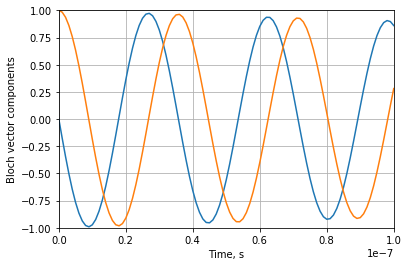

In [9]:
#showing oscillating Bloch vector components

plt.plot(rabi_oscillations["time"], 
         np.real(rabi_oscillations["sigma_y_1"]) ) 
plt.plot(rabi_oscillations["time"], 
         np.real(rabi_oscillations["sigma_z_1"]) )

plt.grid()
plt.rc('grid', linestyle="dotted", color='gray') #adding grid

plt.xlabel("Time, s")
plt.ylabel("Bloch vector components")
plt.axis([0,1e-7,-1,1])

plt.show()




Clearly, the theoretical oscillation period $T_{th}=\pi\hbar/\mu_B B_{x}$ = 35.7 ns is in good agreement with the simulated result.  

The plots of purity and fidelity with respect to the initial state reveal the dephasing process with time constant $T_2$: 

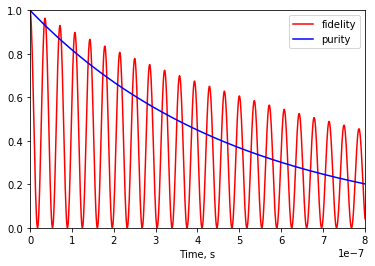

In [10]:
#showing dephasing

plt.plot(rabi_oscillations["time"], 
         np.real(rabi_oscillations["fidelity"]),'r', label="fidelity") 
plt.plot(rabi_oscillations["time"], 
         np.real(rabi_oscillations["purity"]), 'b', label="purity" )

plt.xlabel("Time, s")
plt.legend(loc="upper right")
plt.axis([0,8e-7,0,1])

plt.show()


The system purity hits the value $1/e$ at around 550 ns, which is consistent with the definition of $T_2=5\cdot10^{-7}$

### Addressing individual qubits with the deviation $g-$factors

If we could address electron g-factors individually, we could tune them on and off resonance. Indeed, the Hamiltonian in this case is as follows (phase is still zero):

$H = \sum_i \frac{\hbar}{2}\left(\omega\left(1+\frac{\delta g_i}{2}\right) - \omega_{RF} \right) \sigma_{z,i} + \frac{\hbar\Omega_x}{2} \sigma_{x,i}$

Consider a two-electron system in the $|\uparrow \downarrow\rangle$ configuration. In this case, we need to specify `delta_g_{i}` control variables. We specify meander-like sequences for them:

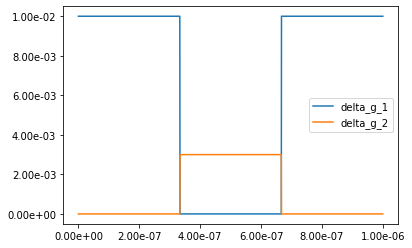

In [11]:
#creating spin system, starting with the same parameters as before
g_manip_system = sps.SpinSys(rho_up_down, sys_param_dict = params_rabi) 
#reducing dissipation
g_manip_system.T_2 = 1e-5

lisdg1 = [1e-2] * 1000 + [0] * 1000 + [1e-2] * 1000   #delta_g_1 pulse
lisdg2 = [0] * 1000 + [3e-3] * 1000 + [0] * 1000      #delta_g_2 pulse

#plotting pulses 
listime = np.linspace(0, 1e-6, num=3000)

fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
     # for scientific  number format

ax.plot(listime, lisdg1, label='delta_g_1')
ax.plot(listime, lisdg2, label='delta_g_2')
ax.legend(loc='center right')


The other variables are chosen so that no deviation in $g-$factor corresponds to the resonance

In [12]:
#starting with the same pulse as before
g_manip_pulse = rabi_test_pulse

# adding g factor control variables 
g_manip_pulse.add_control_variable("delta_g_1", np.array(lisdg1))
g_manip_pulse.add_control_variable("delta_g_2", np.array(lisdg2))

# performing the system evolution
g_manip = g_manip_system.evolve(g_manip_pulse, track_qubits={1,2}, 
                                are_Bloch_vectors=True,track_points_per_pulse=1000)    


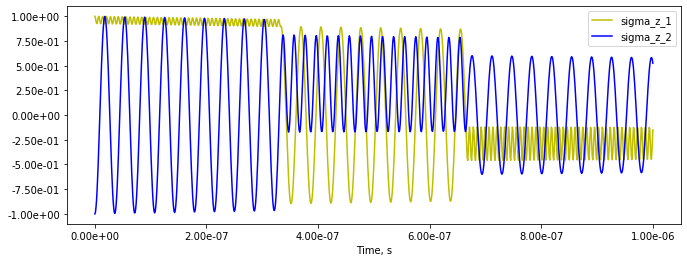

In [13]:
#plotting the results
fig, ax = plt.subplots(figsize=(11,4))
#fig = plt.figure(figsize=(11,4))

ax.plot(g_manip["time"], np.real(g_manip["sigma_z_1"]) ,"y", label='sigma_z_1')
ax.plot(g_manip["time"], np.real(g_manip["sigma_z_2"]) ,"b", label='sigma_z_2')
ax.legend(loc='upper right')
plt.xlabel("Time, s")

ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
     # for scientific  number format


Clearly, the case of larger deviation in g-factor corresponds to a better addressation since it gives smaller residual ripple

## 5. Simulating quantum gates

### Single qubit rotations

$ROTX(\theta)$ and $ROTY(\theta)$ gates could be easily implemented with the aid of ESR pulses. Assuming we are on resonance, the full ESR Hamiltonian is $H = \frac{\hbar}{2} \left( \Omega_x \sigma_x \cos \phi  + \Omega_y \sigma_y \cos \phi \right)$.

At $\phi=0, \pi$, we obtain ROTX gate. The evolution operator:
$U = \exp\left(-\frac{iHt}{\hbar}\right) = \exp\left(-\frac{i\Omega_x t\sigma_x}{2}\right) $. 

On the other hand, $ROTX(\theta) = \exp \left( -\frac{i\theta \sigma_x}{2} \right)$. Thus we obtain $\theta = {\Omega_x t}$ so that $t = \frac{\theta}{\Omega_x} = \frac{\theta \hbar}{2\mu_B B_x}$

Analogously, $ROTY(\theta)$ is implemented at $\phi=\pm \pi/2$ with $\theta = \Omega_y t$, and $t = \frac{\theta}{\Omega_x} = \frac{\theta \hbar}{2\mu_B B_x}$


As regards  $ROTZ(\theta)$ gate, its most straightforward construction is as follows: $ROTZ(\theta) = ROTX(-\frac{\pi}{2}) ROTY(\theta) ROTX(\frac{\pi}{2})$. The other possibility is to employ deviation $g-$factor (TODO: complete)

In [21]:
#implementing ROTZ(pi/4) gate on a spin-up qubit

#starting with the superposition state $1/\sqrt{2} (|0\rangle + |1\rangle)$
rho_sup = np.array([[0.5,0.5],[0.5,0.5]])

rabi_system = sps.SpinSys(rho_sup, sys_param_dict={"B_0" : 1, "T_2" : 1e-6, "T" : 4, "f_rf"  : 2.799249E10}, 
                           time=0)

#defining ROTX(3\pi/2) pulse

rotx3pi2_length = 3*math.pi 
rotx3pi2 = circ.ControlPulse("ROTX3pi2", "effective", pulse_length=1e-7)

roty1pi4 = circ.ControlPulse("ROTX1pi4", "effective", pulse_length=1e-7) 
